In [70]:
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor

import optuna.visualization as vis
import xgboost as xgb 

import numpy as np
import optuna
import sys
import joblib
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib
import pickle

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

import joblib
from sklearn.model_selection import train_test_split


## Loading Data

In [128]:
train_val = pd.read_csv('../split_income_data/train_val.csv')
train_val = train_val.drop(columns=['Unnamed: 0'], axis=1)

train_val_low = train_val[train_val['income_num'] == 1]
train_val_input_low = train_val_low.drop(columns=['setting', 'date', 'Maternal mortality ratio (national estimate, per 100,000 live births)'], axis=1)
train_val_label_low = train_val_low['Maternal mortality ratio (national estimate, per 100,000 live births)']

train_val_ul = train_val[train_val['income_num'] == 2]
train_val_input_ul = train_val_ul.drop(columns=['setting', 'date', 'Maternal mortality ratio (national estimate, per 100,000 live births)'], axis=1)
train_val_label_ul = train_val_ul['Maternal mortality ratio (national estimate, per 100,000 live births)']

train_val_um = train_val[train_val['income_num'] == 3]
train_val_input_um = train_val_um.drop(columns=['setting', 'date', 'Maternal mortality ratio (national estimate, per 100,000 live births)'], axis=1)
train_val_label_um = train_val_um['Maternal mortality ratio (national estimate, per 100,000 live births)']

train_val_high = train_val[train_val['income_num'] == 4]
train_val_input_high = train_val_high.drop(columns=['setting', 'date', 'Maternal mortality ratio (national estimate, per 100,000 live births)'], axis=1)
train_val_label_high = train_val_high['Maternal mortality ratio (national estimate, per 100,000 live births)']

train_val_pre = train_val[train_val['date'] < 2000]
train_val_input_pre = train_val_pre.drop(columns=['setting', 'date', 'Maternal mortality ratio (national estimate, per 100,000 live births)'], axis=1)
train_val_label_pre = train_val_pre['Maternal mortality ratio (national estimate, per 100,000 live births)']

train_val_post = train_val[train_val['date'] >= 2000]
train_val_input_post = train_val_post.drop(columns=['setting', 'date', 'Maternal mortality ratio (national estimate, per 100,000 live births)'], axis=1)
train_val_label_post = train_val_post['Maternal mortality ratio (national estimate, per 100,000 live births)']

In [129]:
train_val['income_num']

0       4.0
1       4.0
2       3.0
3       4.0
4       4.0
       ... 
2492    4.0
2493    3.0
2494    3.0
2495    4.0
2496    3.0
Name: income_num, Length: 2497, dtype: float64

## Predictions From Base Estimators 

### Function

In [202]:
def get_predictions(model_name, features, sensitivity, train_val_data):
    tvd = train_val_data.copy()
    models = []
    train_val_predictions = []
    test_predictions = []

    for fold, fold_num in enumerate(['0', '1', '2', '3', '4']):
        for thresh, thresh_name in enumerate(['Threshold 85%', 'Threshold 90%', 'Threshold 95%', 'None']):
            
            if thresh == 0:
                name = '85'
            elif thresh == 1:
                name = '90'
            elif thresh == 2:
                name = '95'
            else: name = '1'

            best_p = joblib.load(f"{sensitivity}/{model_name}/best_params_{fold}_{name}_{features}.pkl")

            train_data_file = 'country_data/' + sensitivity + '_inc.pkl'
            with open(train_data_file, 'rb') as f:
                train_data = joblib.load(f)

            train_x = train_data[int(fold)][features][thresh*2].copy()
            train_x = train_x.drop(columns=['index'], axis=1)
            train_y = train_data[int(fold)][features][thresh*2 + 1].copy()

            test_data_file = 'country_data/test_' +  sensitivity + '_inc.pkl'
            with open(test_data_file, 'rb') as f:
                test_data = joblib.load(f)
            test_x = test_data[0].drop(columns=['Unnamed: 0'])
            test_y = test_data[1]

            if model_name == 'rf':
                loaded_model = RandomForestRegressor(**best_p)
                
            elif model_name == 'xgb':
                loaded_model = xgb.XGBRegressor(**best_p)

            elif model_name == 'lgb':
                train_x.columns = train_x.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)
                train_y.column = 'Maternal mortality ratio (national estimate per 100000 live births)'
                tvd.columns = tvd.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)
                test_x.columns = test_x.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)

                loaded_model = lgb.LGBMRegressor(**best_p, verbosity = -1)     

            train_load = loaded_model.fit(train_x, train_y)
            models.append(train_load)
            
            train_val_input_relevant = tvd[train_x.columns].copy()
            train_val_predictions.append(train_load.predict(train_val_input_relevant))
            
            test_relevant = test_x[train_x.columns].copy()
            test_predictions.append(train_load.predict(test_relevant))

    return models, train_val_predictions, test_predictions

### Utilising Function

predictions_lgb + predictions_rf + predictions_xgb

0-19: lightgbm all features
20-39: lightgbm literature features
40-59: lightgbm correlation 60
60-79: lightgbm correlation 70
80-99: lightgbm correlation 80

100-119: random forest all features
120-139: random forest literature features
140-159: random forest correlation 70
160-179: random forest correlation 60
180-199: random forest correlation 80

200-219: xgboost all features
220-239: xgboost literature features
240-259: xgboost forest correlation 60
260-279: xgboost forest correlation 70
280-299: xgboost forest correlation 80

### Low

In [146]:
rf_models_low = []
rf_predictions_low = []
rf_test_predictions_low = []

xgb_models_low = []
xgb_predictions_low = []
xgb_test_predictions_low = []

lgbm_models_low = []
lgbm_predictions_low = []
lgbm_test_predictions_low = []

In [147]:
for model_name in ['lgb', 'rf', 'xgb']:
    for feature in ['full', 'lit', 'corr_60', 'corr_70', 'corr_80']:
        model, pred, test_pred = get_predictions(model_name, feature, 'low', train_val_input_low)
    
        if model_name == 'lgb':
            lgbm_models_low.append(model)
            for p in pred:
                lgbm_predictions_low.append(p)
            for pt in test_pred:
                lgbm_test_predictions_low.append(pt)

        if model_name == 'rf':
            rf_models_low.append(model)
            for p in pred:
                rf_predictions_low.append(p)
            for pt in test_pred:
                rf_test_predictions_low.append(pt)

        if model_name == 'xgb':
            xgb_models_low.append(model)
            for p in pred:
                xgb_predictions_low.append(p)
            for pt in test_pred:
                xgb_test_predictions_low.append(pt)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,),

In [148]:
full_predictions_low = lgbm_predictions_low + rf_predictions_low + xgb_predictions_low
stacked_predictions_low = np.column_stack(full_predictions_low)
joblib.dump(stacked_predictions_low, f"ensemble/income/stacked_predictions_low.pkl")

full_test_predictions_low = lgbm_test_predictions_low + rf_test_predictions_low + xgb_test_predictions_low
stacked_test_predictions_low = np.column_stack(full_test_predictions_low)
joblib.dump(stacked_test_predictions_low, f"ensemble/income/stacked_test_predictions_low.pkl")

['ensemble/income/stacked_test_predictions_low.pkl']

In [149]:
len(lgbm_predictions_low), len(rf_predictions_low), len(xgb_predictions_low)

(100, 100, 100)

In [141]:
train_val_label_low.shape, train_val_input_low.shape

((68,), (68, 720))

In [150]:
stacked_predictions_low.shape

(68, 300)

In [151]:
X_meta_train_low, X_meta_val_low, y_meta_train_low, y_meta_val_low = train_test_split(
    stacked_predictions_low, train_val_label_low, test_size=0.2, random_state=42
)

### Lower Middle

In [157]:
rf_models_ul = []
rf_predictions_ul = []
rf_test_predictions_ul = []

xgb_models_ul = []
xgb_predictions_ul = []
xgb_test_predictions_ul = []

lgbm_models_ul = []
lgbm_predictions_ul = []
lgbm_test_predictions_ul = []

In [158]:
for model_name in ['lgb', 'rf', 'xgb']:
    for feature in ['full', 'lit', 'corr_60', 'corr_70', 'corr_80']:
        model, pred, test_pred = get_predictions(model_name, feature, 'ul', train_val_input_ul)
    
        if model_name == 'lgb':
            lgbm_models_ul.append(model)
            for p in pred:
                lgbm_predictions_ul.append(p)
            for pt in test_pred:
                lgbm_test_predictions_ul.append(pt)

        if model_name == 'rf':
            rf_models_ul.append(model)
            for p in pred:
                rf_predictions_ul.append(p)
            for pt in test_pred:
                rf_test_predictions_ul.append(pt)

        if model_name == 'xgb':
            xgb_models_ul.append(model)
            for p in pred:
                xgb_predictions_ul.append(p)
            for pt in test_pred:
                xgb_test_predictions_ul.append(pt)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,),

In [159]:
full_predictions_ul = lgbm_predictions_ul + rf_predictions_ul + xgb_predictions_ul
stacked_predictions_ul = np.column_stack(full_predictions_ul)
joblib.dump(stacked_predictions_ul, f"ensemble/income/stacked_predictions_ul.pkl")

full_test_predictions_ul = lgbm_test_predictions_ul + rf_test_predictions_ul + xgb_test_predictions_ul
stacked_test_predictions_ul = np.column_stack(full_test_predictions_ul)
joblib.dump(stacked_test_predictions_ul, f"ensemble/income/stacked_test_predictions_ul.pkl")

['ensemble/income/stacked_test_predictions_ul.pkl']

In [160]:
X_meta_train_ul, X_meta_val_ul, y_meta_train_ul, y_meta_val_ul = train_test_split(
    stacked_predictions_ul, train_val_label_ul, test_size=0.2, random_state=42
)

### Upper Middle

In [170]:
rf_models_um = []
rf_predictions_um = []
rf_test_predictions_um = []

xgb_models_um = []
xgb_predictions_um = []
xgb_test_predictions_um = []

lgbm_models_um = []
lgbm_predictions_um = []
lgbm_test_predictions_um = []

In [171]:
for model_name in ['lgb', 'rf', 'xgb']:
    for feature in ['full', 'lit', 'corr_60', 'corr_70', 'corr_80']:
        model, pred, test_pred = get_predictions(model_name, feature, 'um', train_val_input_um)
    
        if model_name == 'lgb':
            lgbm_models_um.append(model)
            for p in pred:
                lgbm_predictions_um.append(p)
            for pt in test_pred:
                lgbm_test_predictions_um.append(pt)

        if model_name == 'rf':
            rf_models_um.append(model)
            for p in pred:
                rf_predictions_um.append(p)
            for pt in test_pred:
                rf_test_predictions_um.append(pt)

        if model_name == 'xgb':
            xgb_models_um.append(model)
            for p in pred:
                xgb_predictions_um.append(p)
            for pt in test_pred:
                xgb_test_predictions_um.append(pt)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,),

In [172]:
full_predictions_um = lgbm_predictions_um + rf_predictions_um + xgb_predictions_um
stacked_predictions_um = np.column_stack(full_predictions_um)
joblib.dump(stacked_predictions_um, f"ensemble/income/stacked_predictions_um.pkl")

full_test_predictions_um = lgbm_test_predictions_um + rf_test_predictions_um + xgb_test_predictions_um
stacked_test_predictions_um = np.column_stack(full_test_predictions_um)
joblib.dump(stacked_test_predictions_um, f"ensemble/income/stacked_test_predictions_um.pkl")

['ensemble/income/stacked_test_predictions_um.pkl']

In [173]:
(stacked_predictions_um.shape)

(896, 300)

In [174]:
X_meta_train_um, X_meta_val_um, y_meta_train_um, y_meta_val_um = train_test_split(
    stacked_predictions_um, train_val_label_um, test_size=0.2, random_state=42
)

### High

In [203]:
rf_models_high = []
rf_predictions_high = []
rf_test_predictions_high = []

xgb_models_high = []
xgb_predictions_high = []
xgb_test_predictions_high = []

lgbm_models_high = []
lgbm_predictions_high = []
lgbm_test_predictions_high = []

In [204]:
for model_name in ['lgb', 'rf', 'xgb']:
    for feature in ['full', 'lit', 'corr_60', 'corr_70', 'corr_80']:
        model, pred, test_pred = get_predictions(model_name, feature, 'high', train_val_input_high)
    
        if model_name == 'lgb':
            lgbm_models_high.append(model)
            for p in pred:
                lgbm_predictions_high.append(p)
            for pt in test_pred:
                lgbm_test_predictions_high.append(pt)

        if model_name == 'rf':
            rf_models_high.append(model)
            for p in pred:
                rf_predictions_high.append(p)
            for pt in test_pred:
                rf_test_predictions_high.append(pt)

        if model_name == 'xgb':
            xgb_models_high.append(model)
            for p in pred:
                xgb_predictions_high.append(p)
            for pt in test_pred:
                xgb_test_predictions_high.append(pt)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,),

In [205]:
full_predictions_high = lgbm_predictions_high + rf_predictions_high + xgb_predictions_high
stacked_predictions_high = np.column_stack(full_predictions_high)
joblib.dump(stacked_predictions_high, f"ensemble/income/stacked_predictions_high.pkl")

full_test_predictions_high = lgbm_test_predictions_high + rf_test_predictions_high + xgb_test_predictions_high
stacked_test_predictions_high = np.column_stack(full_test_predictions_high)
joblib.dump(stacked_test_predictions_high, f"ensemble/income/stacked_test_predictions_high.pkl")

['ensemble/income/stacked_test_predictions_high.pkl']

In [206]:
X_meta_train_high, X_meta_val_high, y_meta_train_high, y_meta_val_high = train_test_split(
    stacked_predictions_high, train_val_label_high, test_size=0.2, random_state=42
)

### Pre-2000s

In [ ]:
rf_models_pre = []
rf_predictions_pre = []
rf_test_predictions_pre = []

xgb_models_pre = []
xgb_predictions_pre = []
xgb_test_predictions_pre = []

lgbm_models_pre = []
lgbm_predictions_pre = []
lgbm_test_predictions_pre = []

In [ ]:
for model_name in ['lgb', 'rf', 'xgb']:
    for feature in ['full', 'lit', 'corr_60', 'corr_70', 'corr_80']:
        model, pred, test_pred = get_predictions(model_name, feature, 'pre', train_val_input_pre)
    
        if model_name == 'lgb':
            lgbm_models_pre.append(model)
            for p in pred:
                lgbm_predictions_pre.append(p)
            for pt in test_pred:
                lgbm_test_predictions_pre.append(pt)

        if model_name == 'rf':
            rf_models_pre.append(model)
            for p in pred:
                rf_predictions_pre.append(p)
            for pt in test_pred:
                rf_test_predictions_pre.append(pt)

        if model_name == 'xgb':
            xgb_models_pre.append(model)
            for p in pred:
                xgb_predictions_pre.append(p)
            for pt in test_pred:
                xgb_test_predictions_pre.append(pt)

In [ ]:
full_predictions_pre = lgbm_predictions_pre + rf_predictions_pre + xgb_predictions_pre
stacked_predictions_pre = np.column_stack(full_predictions_pre)
joblib.dump(stacked_predictions_pre, f"ensemble/income/stacked_predictions_pre.pkl")

full_test_predictions_pre = lgbm_test_predictions_pre + rf_test_predictions_pre + xgb_test_predictions_pre
stacked_test_predictions_pre = np.column_stack(full_test_predictions_pre)
joblib.dump(stacked_test_predictions_pre, f"ensemble/income/stacked_test_predictions_pre.pkl")

In [ ]:
X_meta_train_pre, X_meta_val_pre, y_meta_train_pre, y_meta_val_pre = train_test_split(
    stacked_predictions_pre, train_val_label_pre, test_size=0.2, random_state=42
)

### 2000-2014

In [ ]:
rf_models_post = []
rf_predictions_post = []
rf_test_predictions_post = []

xgb_models_post = []
xgb_predictions_post = []
xgb_test_predictions_post = []

lgbm_models_post = []
lgbm_predictions_post = []
lgbm_test_predictions_post = []

In [ ]:
for model_name in ['lgb', 'rf', 'xgb']:
    for feature in ['full', 'lit', 'corr_60', 'corr_70', 'corr_80']:
        model, pred, test_pred = get_predictions(model_name, feature, 'post', train_val_input_post)
    
        if model_name == 'lgb':
            lgbm_models_post.append(model)
            for p in pred:
                lgbm_predictions_post.append(p)
            for pt in test_pred:
                lgbm_test_predictions_post.append(pt)

        if model_name == 'rf':
            rf_models_post.append(model)
            for p in pred:
                rf_predictions_post.append(p)
            for pt in test_pred:
                rf_test_predictions_post.append(pt)

        if model_name == 'xgb':
            xgb_models_post.append(model)
            for p in pred:
                xgb_predictions_post.append(p)
            for pt in test_pred:
                xgb_test_predictions_post.append(pt)

In [ ]:
full_predictions_post = lgbm_predictions_post + rf_predictions_post + xgb_predictions_post
stacked_predictions_post = np.column_stack(full_predictions_post)
joblib.dump(stacked_predictions_post, f"ensemble/income/stacked_predictions_post.pkl")

full_test_predictions_post = lgbm_test_predictions_post + rf_test_predictions_post + xgb_test_predictions_post
stacked_test_predictions_post = np.column_stack(full_test_predictions_post)
joblib.dump(stacked_test_predictions_post, f"ensemble/income/stacked_test_predictions_post.pkl")

In [ ]:
X_meta_train_post, X_meta_val_post, y_meta_train_post, y_meta_val_post = train_test_split(
    stacked_predictions_post, train_val_label_post, test_size=0.2, random_state=42
)

## Training Random Forest Ensemble

### Objective Function

In [178]:
def stacked_objective_rf(trial, X_meta_train, y_meta_train, X_meta_val, y_meta_val):

    n_trees = trial.suggest_int("n_estimators", 10, 300)

    max_depth = trial.suggest_int("max_depth", 3, 25)

    min_sample_split = trial.suggest_int("min_samples_split", 2, 10)

    bootstrapping = trial.suggest_categorical("bootstrap", [True, False])
    if bootstrapping == False:
        max_samples = None
    else:
        max_samples = trial.suggest_float("max_samples", 0.01, 1.0)

    rf = RandomForestRegressor(random_state=42, n_jobs=-1, min_samples_split=min_sample_split, bootstrap=bootstrapping, max_samples=max_samples, n_estimators=n_trees, max_depth=max_depth)
    
    rf.fit(X_meta_train, y_meta_train)
    rf_predictions = rf.predict(X_meta_val)

    return mean_squared_error(y_meta_val, rf_predictions)

### Building Ensemble Models

In [179]:
rf_stacking_study_low = optuna.create_study(direction='minimize')
rf_stacking_study_low.optimize(lambda trial: stacked_objective_rf(trial, X_meta_train_low, y_meta_train_low, X_meta_val_low, y_meta_val_low), n_trials=1000)
joblib.dump(rf_stacking_study_low.best_params, f"ensemble/income/rf_stacking_best_params_low.pkl")
joblib.dump(rf_stacking_study_low, f"ensemble/income/rf_stacking_optuna_study_low.pkl")

best_rf_model_low = RandomForestRegressor(**rf_stacking_study_low.best_params)
best_rf_model_low.fit(stacked_predictions_low, train_val_label_low)
joblib.dump(best_rf_model_low, "ensemble/income/rf_stacking_best_model_low.pkl")

[I 2025-09-01 22:44:00,252] A new study created in memory with name: no-name-e533a597-88c4-490e-9e8b-8ae2dbcfac09
[I 2025-09-01 22:44:00,424] Trial 0 finished with value: 4699.607901618552 and parameters: {'n_estimators': 169, 'max_depth': 21, 'min_samples_split': 9, 'bootstrap': False}. Best is trial 0 with value: 4699.607901618552.
[I 2025-09-01 22:44:00,563] Trial 1 finished with value: 20758.44328509764 and parameters: {'n_estimators': 295, 'max_depth': 21, 'min_samples_split': 10, 'bootstrap': True, 'max_samples': 0.36784519996672016}. Best is trial 0 with value: 4699.607901618552.
[I 2025-09-01 22:44:00,660] Trial 2 finished with value: 7801.076189355721 and parameters: {'n_estimators': 144, 'max_depth': 8, 'min_samples_split': 8, 'bootstrap': True, 'max_samples': 0.9694422041601316}. Best is trial 0 with value: 4699.607901618552.
[I 2025-09-01 22:44:00,729] Trial 3 finished with value: 2392.575418180559 and parameters: {'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 

['ensemble/income/rf_stacking_best_model_low.pkl']

In [180]:
rf_stacking_study_ul = optuna.create_study(direction='minimize')
rf_stacking_study_ul.optimize(lambda trial: stacked_objective_rf(trial, X_meta_train_ul, y_meta_train_ul, X_meta_val_ul, y_meta_val_ul), n_trials=1000)
joblib.dump(rf_stacking_study_ul.best_params, f"ensemble/income/rf_stacking_best_params_ul.pkl")
joblib.dump(rf_stacking_study_ul, f"ensemble/income/rf_stacking_optuna_study_ul.pkl")

best_rf_model_ul = RandomForestRegressor(**rf_stacking_study_ul.best_params)
best_rf_model_ul.fit(stacked_predictions_ul, train_val_label_ul)
joblib.dump(best_rf_model_ul, "ensemble/income/rf_stacking_best_model_ul.pkl")

[I 2025-09-01 22:46:01,867] A new study created in memory with name: no-name-52b3cd02-f445-4d32-9f33-b23adada6efd
[I 2025-09-01 22:46:02,735] Trial 0 finished with value: 1015.2173102890155 and parameters: {'n_estimators': 153, 'max_depth': 16, 'min_samples_split': 10, 'bootstrap': False}. Best is trial 0 with value: 1015.2173102890155.
[I 2025-09-01 22:46:05,257] Trial 1 finished with value: 999.2778617259567 and parameters: {'n_estimators': 285, 'max_depth': 23, 'min_samples_split': 10, 'bootstrap': False}. Best is trial 1 with value: 999.2778617259567.
[I 2025-09-01 22:46:06,740] Trial 2 finished with value: 1005.50302865714 and parameters: {'n_estimators': 260, 'max_depth': 11, 'min_samples_split': 10, 'bootstrap': False}. Best is trial 1 with value: 999.2778617259567.
[I 2025-09-01 22:46:07,542] Trial 3 finished with value: 519.1462662353998 and parameters: {'n_estimators': 134, 'max_depth': 11, 'min_samples_split': 5, 'bootstrap': False}. Best is trial 3 with value: 519.146266235

['ensemble/income/rf_stacking_best_model_ul.pkl']

In [181]:
rf_stacking_study_um = optuna.create_study(direction='minimize')
rf_stacking_study_um.optimize(lambda trial: stacked_objective_rf(trial, X_meta_train_um, y_meta_train_um, X_meta_val_um, y_meta_val_um), n_trials=1000)
joblib.dump(rf_stacking_study_um.best_params, f"ensemble/income/rf_stacking_best_params_um.pkl")
joblib.dump(rf_stacking_study_um, f"ensemble/income/rf_stacking_optuna_study_um.pkl")

best_rf_model_um = RandomForestRegressor(**rf_stacking_study_um.best_params)
best_rf_model_um.fit(stacked_predictions_um, train_val_label_um)
joblib.dump(best_rf_model_um, "ensemble/income/rf_stacking_best_model_um.pkl")

[I 2025-09-01 22:54:52,626] A new study created in memory with name: no-name-05ba76e4-97bd-4e38-ad5e-d5598ae34fff
[I 2025-09-01 22:54:56,020] Trial 0 finished with value: 235.67325862577914 and parameters: {'n_estimators': 200, 'max_depth': 6, 'min_samples_split': 4, 'bootstrap': True, 'max_samples': 0.8837182494663111}. Best is trial 0 with value: 235.67325862577914.
[I 2025-09-01 22:54:56,678] Trial 1 finished with value: 310.6161037324264 and parameters: {'n_estimators': 102, 'max_depth': 15, 'min_samples_split': 7, 'bootstrap': True, 'max_samples': 0.38522448655085284}. Best is trial 0 with value: 235.67325862577914.
[I 2025-09-01 22:55:00,476] Trial 2 finished with value: 222.50786262971653 and parameters: {'n_estimators': 156, 'max_depth': 23, 'min_samples_split': 7, 'bootstrap': False}. Best is trial 2 with value: 222.50786262971653.
[I 2025-09-01 22:55:06,578] Trial 3 finished with value: 204.01363231055623 and parameters: {'n_estimators': 230, 'max_depth': 16, 'min_samples_spl

['ensemble/income/rf_stacking_best_model_um.pkl']

In [208]:
rf_stacking_study_high = optuna.create_study(direction='minimize')
rf_stacking_study_high.optimize(lambda trial: stacked_objective_rf(trial, X_meta_train_high, y_meta_train_high, X_meta_val_high, y_meta_val_high), n_trials=1000)
joblib.dump(rf_stacking_study_high.best_params, f"ensemble/income/rf_stacking_best_params_high.pkl")
joblib.dump(rf_stacking_study_high, f"ensemble/income/rf_stacking_optuna_study_high.pkl")

best_rf_model_high = RandomForestRegressor(**rf_stacking_study_high.best_params)
best_rf_model_high.fit(stacked_predictions_high, train_val_label_high)
joblib.dump(best_rf_model_high, "ensemble/income/rf_stacking_best_model_high.pkl")

[I 2025-09-02 14:18:25,399] A new study created in memory with name: no-name-b2b67569-df9a-4af4-b133-d445514c6725
[I 2025-09-02 14:18:27,178] Trial 0 finished with value: 12.413645263007064 and parameters: {'n_estimators': 250, 'max_depth': 8, 'min_samples_split': 6, 'bootstrap': True, 'max_samples': 0.3566294285606782}. Best is trial 0 with value: 12.413645263007064.
[I 2025-09-02 14:18:30,244] Trial 1 finished with value: 5.494422142287253 and parameters: {'n_estimators': 103, 'max_depth': 21, 'min_samples_split': 5, 'bootstrap': False}. Best is trial 1 with value: 5.494422142287253.
[I 2025-09-02 14:18:36,095] Trial 2 finished with value: 6.28820631369475 and parameters: {'n_estimators': 184, 'max_depth': 15, 'min_samples_split': 9, 'bootstrap': False}. Best is trial 1 with value: 5.494422142287253.
[I 2025-09-02 14:18:41,099] Trial 3 finished with value: 5.791690009053882 and parameters: {'n_estimators': 135, 'max_depth': 25, 'min_samples_split': 7, 'bootstrap': False}. Best is tri

['ensemble/income/rf_stacking_best_model_high.pkl']

In [ ]:
rf_stacking_study_pre = optuna.create_study(direction='minimize')
rf_stacking_study_pre.optimize(lambda trial: stacked_objective_rf(trial, X_meta_train_pre, y_meta_train_pre, X_meta_val_pre, y_meta_val_pre), n_trials=1000)
joblib.dump(rf_stacking_study_pre.best_params, f"ensemble/income/rf_stacking_best_params_re.pkl")
joblib.dump(rf_stacking_study_pre, f"ensemble/income/rf_stacking_optuna_study_pre.pkl")

best_rf_model_pre = RandomForestRegressor(**rf_stacking_study_pre.best_params)
best_rf_model_pre.fit(stacked_predictions_pre, train_val_label_pre)
joblib.dump(best_rf_model_pre, "ensemble/income/rf_stacking_best_model_pre.pkl")

In [ ]:
rf_stacking_study_post = optuna.create_study(direction='minimize')
rf_stacking_study_post.optimize(lambda trial: stacked_objective_rf(trial, X_meta_train_post, y_meta_train_post, X_meta_val_post, y_meta_val_post), n_trials=1000)
joblib.dump(rf_stacking_study_post.best_params, f"ensemble/income/rf_stacking_best_params_post.pkl")
joblib.dump(rf_stacking_study_post, f"ensemble/income/rf_stacking_optuna_study_post.pkl")

best_rf_model_post = RandomForestRegressor(**rf_stacking_study_post.best_params)
best_rf_model_post.fit(stacked_predictions_post, train_val_label_post)
joblib.dump(best_rf_model_post, "ensemble/income/rf_stacking_best_model_post.pkl")

## Evaluating Ensembles

In [237]:
# setting up the dataframe to hold test results
index_rows = pd.MultiIndex.from_tuples(
    [('Original', 'Low'), ('Sensitivity', 'Low'), ('Original', 'Lower Middle'), ('Sensitivity', 'Lower Middle'), 
     ('Original', 'Upper Middle'), ('Sensitivity', 'Upper Middle'), ('Original', 'High'), ('Sensitivity', 'High')],
    names=['Model Type', 'Type of Sensitivity']
)

index_cols = ['MSE', 'MAE', 'R2', 'RMSE', 'Relative Error']

test_stats = pd.DataFrame(index=index_rows, columns=index_cols)

test_stats

,,MSE,MAE,R2,RMSE,Relative Error
Model Type,Type of Sensitivity,,,,,
Original,Low,NaN,NaN,NaN,NaN,NaN
Sensitivity,Low,NaN,NaN,NaN,NaN,NaN
Original,Lower Middle,NaN,NaN,NaN,NaN,NaN
Sensitivity,Lower Middle,NaN,NaN,NaN,NaN,NaN
Original,Upper Middle,NaN,NaN,NaN,NaN,NaN
Sensitivity,Upper Middle,NaN,NaN,NaN,NaN,NaN
Original,High,NaN,NaN,NaN,NaN,NaN
Sensitivity,High,NaN,NaN,NaN,NaN,NaN


In [210]:
best_rf_model_low = joblib.load("ensemble/income/rf_stacking_best_model_low.pkl")
best_rf_model_ul = joblib.load("ensemble/income/rf_stacking_best_model_ul.pkl")
best_rf_model_um = joblib.load("ensemble/income/rf_stacking_best_model_um.pkl")
best_rf_model_high = joblib.load("ensemble/income/rf_stacking_best_model_high.pkl")
#best_rf_model_pre = joblib.load("ensemble/income/rf_stacking_best_model_pre.pkl")
#best_rf_model_post = joblib.load("ensemble/income/rf_stacking_best_model_post.pkl")

In [222]:
rf_pred_low = best_rf_model_low.predict(stacked_test_predictions_low)
rf_pred_ul = best_rf_model_ul.predict(stacked_test_predictions_ul)
rf_pred_um = best_rf_model_um.predict(stacked_test_predictions_um)
rf_pred_high = best_rf_model_high.predict(stacked_test_predictions_high)
#rf_pred_pre = best_rf_model_low.predict(stacked_test_predictions_pre)
#rf_pred_post = best_rf_model_low.predict(stacked_test_predictions_post)

In [212]:
original_rf_ensemble = joblib.load("../split_income_models/ensemble/rf_stacking_best_model.pkl")
stacked_test_predictions_original = joblib.load('../split_income_models/ensemble/stacked_test_predictions.pkl')
rf_pred_original = original_rf_ensemble.predict(stacked_test_predictions_original)

In [213]:
test_data_x_original = pd.read_csv('../split_income_data/test/X_test.csv')
test_data_x_original = test_data_x_original.drop(columns=['Unnamed: 0'], axis=1)
test_data_y_original = pd.read_csv('../split_income_data/test/y_test.csv')
test_data_y_original = test_data_y_original.drop(columns=['Unnamed: 0'], axis=1)

In [246]:
#to evaluate the models' test_predictions
for model in ['Low', 'Lower Middle', 'Upper Middle', 'High']:#, 'pre-2000', 'post-2000']:
    if model == 'Low':
        test_prediction = rf_pred_low
        test_prediction_original = original_rf_ensemble.predict(stacked_test_predictions_low)
        test_data_file = 'country_data/test_low_inc.pkl'
        with open(test_data_file, 'rb') as f:
            test_data = joblib.load(f)
        testing_data = test_data[1]

    elif model == 'Lower Middle':
        test_prediction = rf_pred_ul
        test_prediction_original = original_rf_ensemble.predict(stacked_test_predictions_ul)
        test_data_file = 'country_data/test_ul_inc.pkl'
        with open(test_data_file, 'rb') as f:
            test_data = joblib.load(f)
        testing_data = test_data[1]

    elif model == 'Upper Middle':
        test_prediction = rf_pred_um
        test_prediction_original = original_rf_ensemble.predict(stacked_test_predictions_um)
        test_data_file = 'country_data/test_um_inc.pkl'
        with open(test_data_file, 'rb') as f:
            test_data = joblib.load(f)
        testing_data = test_data[1]

    elif model == 'High':
        test_prediction = rf_pred_high
        test_prediction_original = original_rf_ensemble.predict(stacked_test_predictions_high)
        test_data_file = 'country_data/test_high_inc.pkl'
        with open(test_data_file, 'rb') as f:
            test_data = joblib.load(f)
        testing_data = test_data[1]

    elif model == 'original':
        test_prediction = rf_pred_original
        testing_data = test_data_y_original

    mse = mean_squared_error(testing_data, test_prediction)
    mae = mean_absolute_error(testing_data, test_prediction)
    rmse = np.sqrt(mse)
    r2 = r2_score(testing_data, test_prediction)

    #to calculate mape
    num_test_predictions = len(test_prediction)
    mape = 0
    for p in range(0, num_test_predictions):
        if (np.abs(test_prediction[p] - testing_data.iloc[p]) / np.maximum(np.abs(test_prediction[p]), np.abs(testing_data.iloc[p]))).isnull().all() == False:
            mape += np.abs(test_prediction[p] - testing_data.iloc[p]) / np.maximum(np.abs(test_prediction[p]), np.abs(testing_data.iloc[p]))
    mape = mape/num_test_predictions

    test_stats.loc[('Sensitivity', model), 'MSE'] = mse
    test_stats.loc[('Sensitivity', model), 'MAE'] = mae
    test_stats.loc[('Sensitivity', model), 'RMSE'] = rmse
    test_stats.loc[('Sensitivity', model), 'R2'] = r2
    test_stats.loc[('Sensitivity', model), 'Relative Error'] = mape[0]

    orig_mse = mean_squared_error(testing_data, test_prediction_original)
    orig_mae = mean_absolute_error(testing_data, test_prediction_original)
    orig_rmse = np.sqrt(orig_mse)
    orig_r2 = r2_score(testing_data, test_prediction_original)

    #to calculate mape
    num_test_predictions_orig = len(test_prediction_original)
    orig_mape = 0
    for p in range(0, num_test_predictions_orig):
        orig_mape += np.abs(test_prediction_original[p] - testing_data.iloc[p]) / np.maximum(np.abs(test_prediction_original[p]), np.abs(testing_data.iloc[p]))
    orig_mape = orig_mape/num_test_predictions_orig

    test_stats.loc[('Original', model), 'MSE'] = orig_mse
    test_stats.loc[('Original', model), 'MAE'] = orig_mae
    test_stats.loc[('Original', model), 'RMSE'] = orig_rmse
    test_stats.loc[('Original', model), 'R2'] = orig_r2
    test_stats.loc[('Original', model), 'Relative Error'] = orig_mape[0]

/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_13346/3849823935.py:56: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_stats.loc[('Sensitivity', model), 'Relative Error'] = mape[0]
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_13346/3849823935.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_stats.loc[('Original', model), 'Relative Error'] = orig_mape[0]
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_13346/3849823935.py:56: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (con

## Comparisons

### Uncertainty

In [ ]:
original_rf_ensemble = joblib.load("../split_income_models/ensemble/rf_stacking_best_model.pkl")
stacked_test_predictions_original = joblib.load('../split_income_models/ensemble/stacked_test_predictions.pkl')

In [269]:
base_models_pred = pd.DataFrame(stacked_test_predictions_original)
base_models_pred.std(axis=1)

0      17.714707
1      15.956861
2      14.529534
3      17.494668
4      13.639584
         ...    
297    17.981723
298    15.001042
299    16.189263
300    22.364825
301    17.041292
Length: 302, dtype: float64

Text(0, 0.5, 'Standard Deviation Across the Base Estimators')

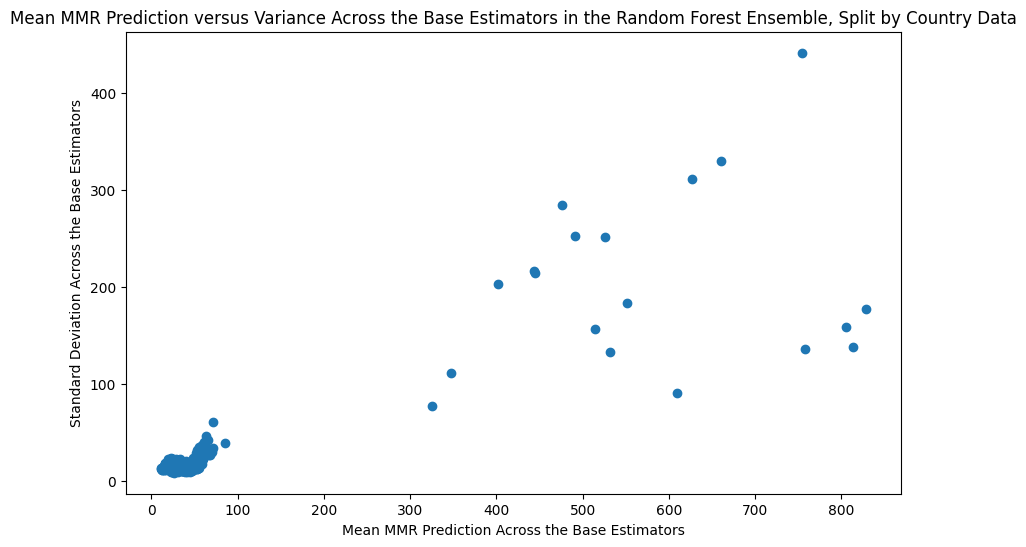

In [271]:
# Plot: Prediction variance vs predicted value
plt.figure(figsize=(10, 6))
plt.scatter(base_models_pred.mean(axis=1), base_models_pred.std(axis=1))
plt.title('Mean MMR Prediction versus Variance Across the Base Estimators in the Random Forest Ensemble, Split by Country Data')
plt.xlabel('Mean MMR Prediction Across the Base Estimators')
plt.ylabel('Standard Deviation Across the Base Estimators')


In [47]:
test_data_x_original = pd.read_csv('../split_income_data/test/X_test.csv')
test_data_x_original = test_data_x_original.drop(columns=['Unnamed: 0'], axis=1)
test_data_y_original = pd.read_csv('../split_income_data/test/y_test.csv')
test_data_y_original = test_data_y_original.drop(columns=['Unnamed: 0'], axis=1)

In [261]:
re_vs_inc

,Income Level,Prediction Error
0,high,0.000537
1,high,0.000372
2,upper middle,0.459525
3,high,0.491267
4,upper middle,0.002268
...,...,...
297,high,0.003610
298,upper middle,0.000743
299,upper middle,0.269989
300,high,0.134522


/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_13346/1714693082.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  re_scores_original[p] = np.abs(original_predictions[p] - test_data_y_original.iloc[p]) / np.maximum(np.abs(original_predictions[p]), np.abs(test_data_y_original.iloc[p]))
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_13346/1714693082.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Income Level', y='Prediction Error', data=re_vs_inc_sorted, palette='Set2')


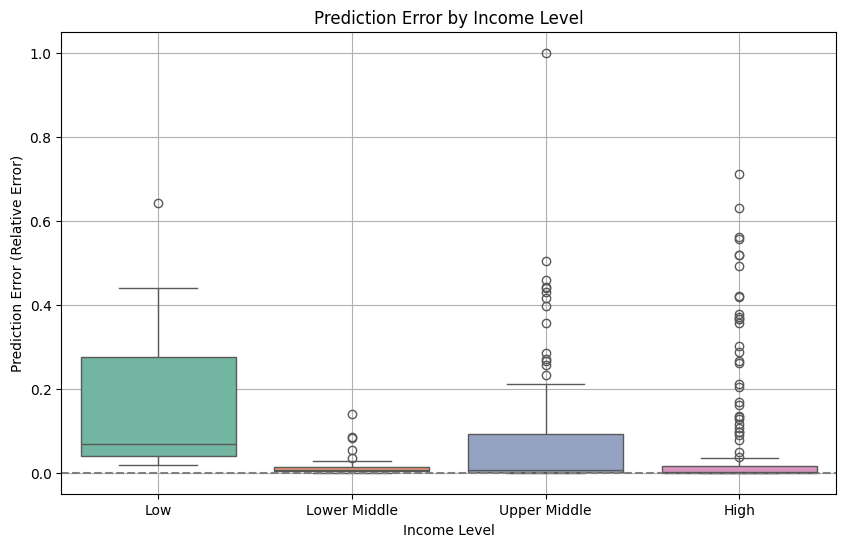

In [266]:
#prediction error versus income level
#to evaluate the models' test_predictions
import seaborn as sns

original_predictions = original_rf_ensemble.predict(stacked_test_predictions_original)
re_scores_original = np.zeros(len(original_predictions))

for p in range(len(original_predictions)):
        re_scores_original[p] = np.abs(original_predictions[p] - test_data_y_original.iloc[p]) / np.maximum(np.abs(original_predictions[p]), np.abs(test_data_y_original.iloc[p]))

test_income_levels = pd.DataFrame(test_data_x_original['income_num'])
test_income_levels.columns = ['income_num']

def income(num):
    if num == 1:
        return 'Low'
    elif num == 2:
        return 'Lower Middle'
    elif num == 3:
        return 'Upper Middle'
    elif num == 4:
        return 'High'

test_income_levels['income'] = test_income_levels['income_num'].apply(income)

re_vs_inc = pd.DataFrame({
    'Income Level': test_income_levels['income'],
    'Prediction Error': re_scores_original
})

income_order = [
    "Low",
    "Lower Middle",
    "Upper Middle",
    "High"
]

re_vs_inc['Income Level'] = pd.Categorical(re_vs_inc['Income Level'], categories=income_order, ordered=True)
re_vs_inc_sorted = re_vs_inc.sort_values(by='Income Level')

plt.figure(figsize=(10, 6))
sns.boxplot(x='Income Level', y='Prediction Error', data=re_vs_inc_sorted, palette='Set2')
plt.axhline(0, color='gray', linestyle='--')
plt.title("Prediction Error by Income Level")
plt.ylabel("Prediction Error (Relative Error)")
plt.xlabel("Income Level")
plt.grid(True)
plt.show()

### Visualisations

In [254]:
test_stats

,,MSE,MAE,R2,RMSE,Relative Error
Model Type,Type of Sensitivity,,,,,
Original,Low,89353.361301,214.974879,0.474854,298.920326,0.224781
Sensitivity,Low,167123.242738,222.698245,0.017786,408.807097,0.194047
Original,Lower Middle,438.596726,14.582637,-0.427608,20.942701,0.272074
Sensitivity,Lower Middle,1827.541344,23.90695,-4.948547,42.749753,0.334203
Original,Upper Middle,114.593095,7.569212,0.627006,10.704816,0.173815
Sensitivity,Upper Middle,231.614844,5.710108,0.246106,15.218898,0.071939
Original,High,19.934133,2.965691,0.939977,4.464766,0.188573
Sensitivity,High,4.610366,0.946728,0.986118,2.147176,0.070369


In [249]:
test_stats['MAE'].unstack(level='Model Type')

Model Type,Original,Sensitivity
Type of Sensitivity,,
High,2.965691,0.946728
Low,214.974879,222.698245
Lower Middle,14.582637,23.90695
Upper Middle,7.569212,5.710108


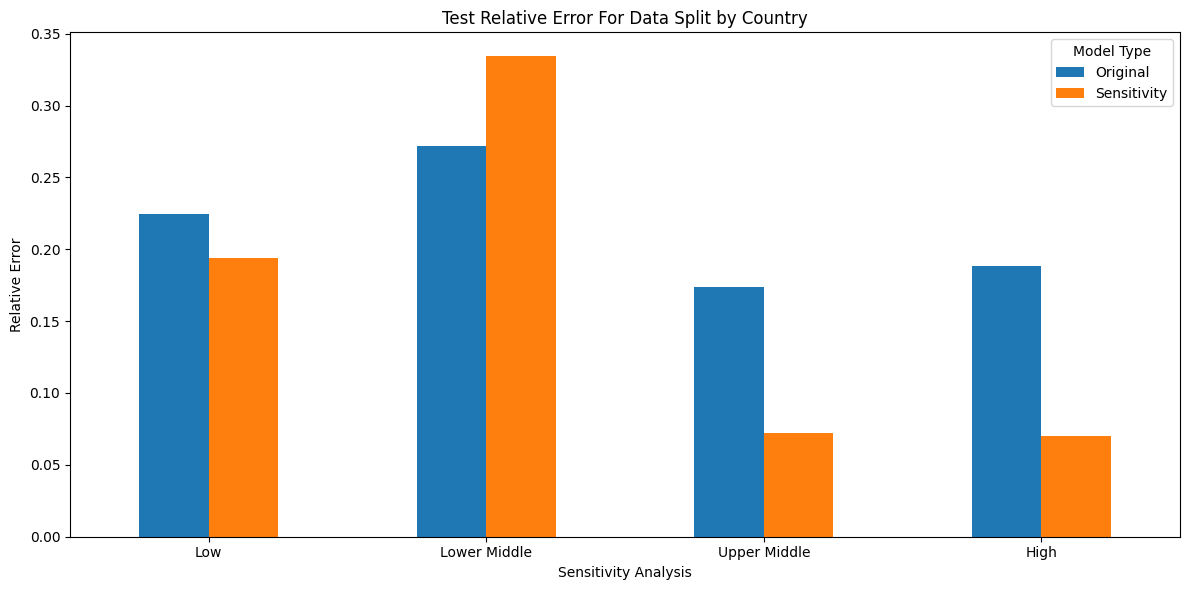

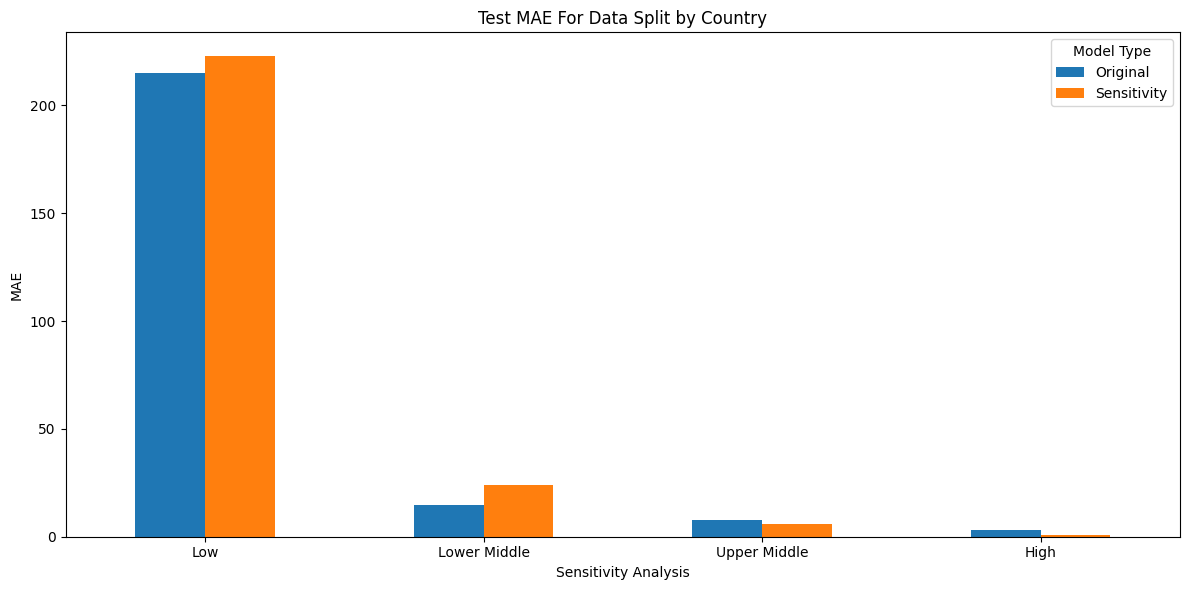

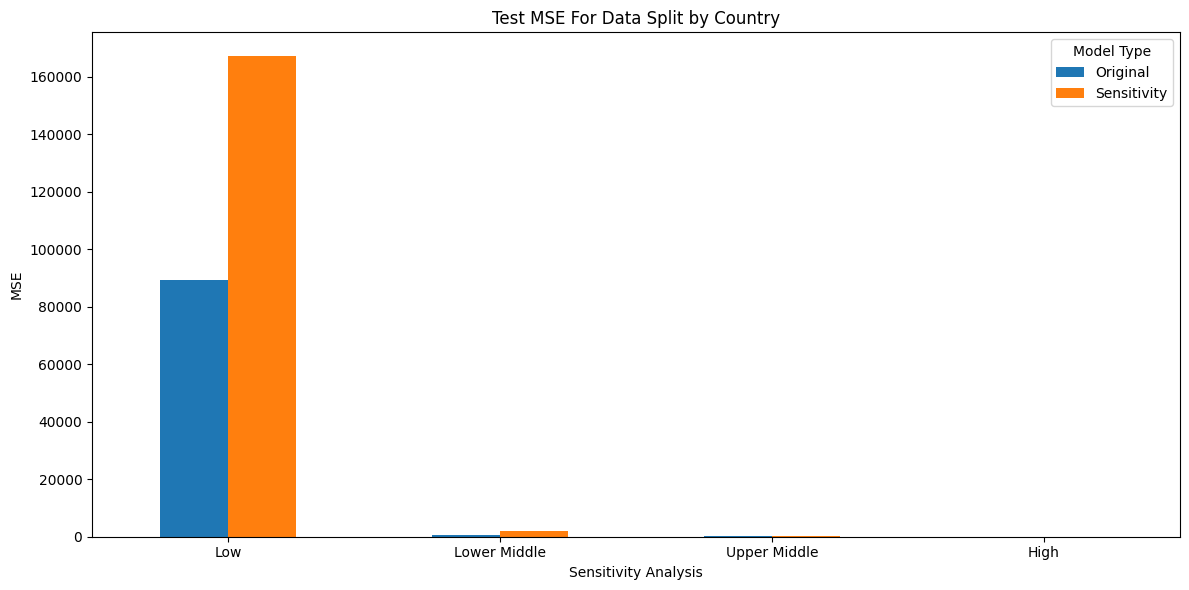

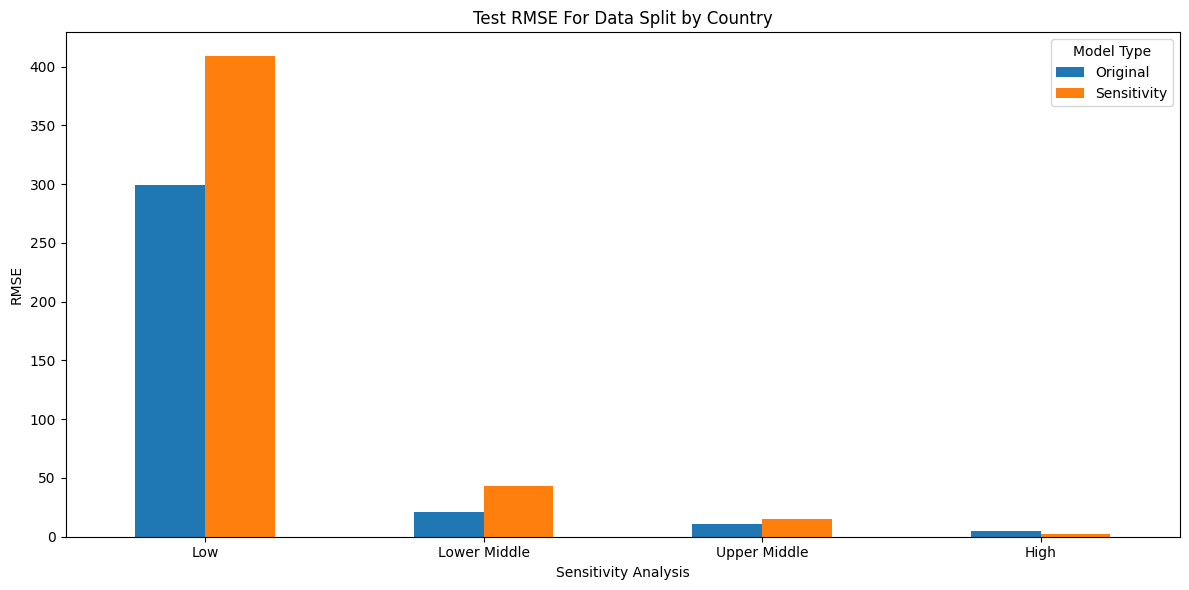

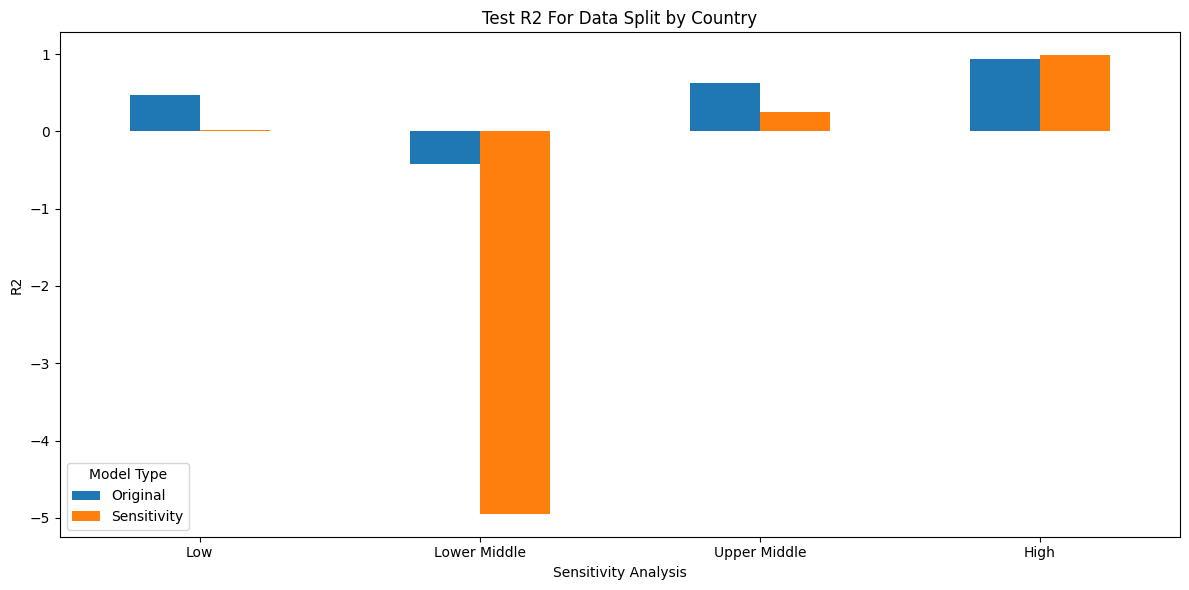

In [253]:
metrics = ['Relative Error', 'MAE', "MSE", 'RMSE', "R2"]

for metric in metrics:
    data_metric = test_stats[metric].unstack(level='Model Type')
    new_order = ['Low', 'Lower Middle', 'Upper Middle', 'High']
    data_metric = data_metric.loc[new_order]
    ax = data_metric.plot.bar(rot=0, figsize=(12, 6))     
    plt.title("Test " + metric + " For Data Split by Country")
    plt.xlabel("Sensitivity Analysis")
    plt.ylabel(metric)
    plt.tight_layout()
    plt.show()